# Rossmann Stores Analysis

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import operator

from sklearn.model_selection import train_test_split
from preprocessing import preprocessing, merge_data
from model import rmse, rmse_XGBoost, create_feature_map

import warnings
warnings.filterwarnings('ignore')

## Variables

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
data_path = 'data/raw/'
results_path = ''
# Load datasets
store = pd.read_csv(data_path + 'store.csv')
train = pd.read_csv(data_path + 'train.csv', low_memory=False)
test = pd.read_csv(data_path + 'test.csv')

## Exploration

### Store data

In [3]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [4]:
store.shape

(1115, 10)

In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [6]:
# Proportion of NaN among the features
store.isna().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [7]:
store.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

This dataset contains $1115$ rows, one for each store. Therefore, the `Store` colums is a primary key of this table.

In [8]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


### Sales data

In [9]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [10]:
train.shape

(1017209, 9)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
train.isna().sum() / train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

There is no null values in the train set.

In [13]:
train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [14]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,2013-03-26,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [15]:
test.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [16]:
test.shape

(41088, 8)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [18]:
test.isna().sum() / test.shape[0]

Id               0.000000
Store            0.000000
DayOfWeek        0.000000
Date             0.000000
Open             0.000268
Promo            0.000000
StateHoliday     0.000000
SchoolHoliday    0.000000
dtype: float64

There is less than $0.03$% of null values in the test set for the `Open` feature.

In [19]:
test.nunique()

Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64

In [20]:
test.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088,41077.000000,41088.000000,41088,41088.000000
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-14,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.500000,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000
25%,10272.750000,279.750000,2.000000,NaN,1.000000,0.000000,NaN,0.000000
50%,20544.500000,553.500000,4.000000,NaN,1.000000,0.000000,NaN,0.000000
75%,30816.250000,832.250000,6.000000,NaN,1.000000,1.000000,NaN,1.000000


## Analysis

### `Open`

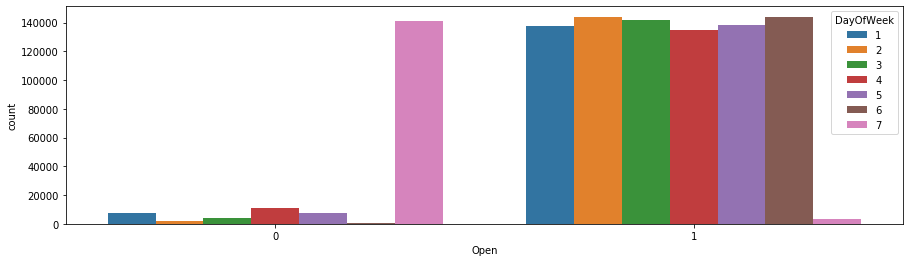

In [21]:
# Plot DayOfWeek for Open
fig, axis = plt.subplots(1, 1, figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek', data=train, ax=axis)

Stores appear to be mostly closed on Sundays and open on other days of the week.

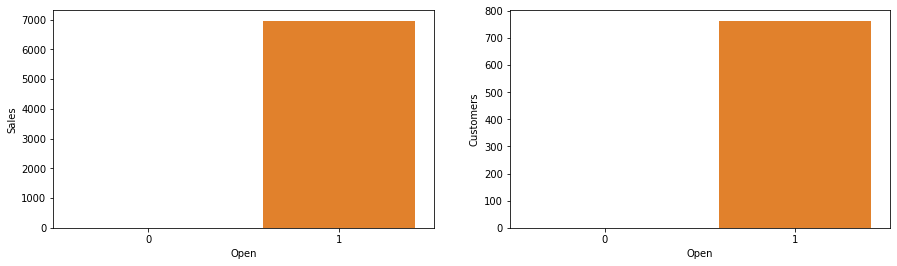

In [22]:
# Plot Sales & Customers for Open
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='Open', y='Sales', data=train, ax=axis1)
sns.barplot(x='Open', y='Customers', data=train, ax=axis2)

A closed shop generates $0$ sale. Therefore, we can set the sales amount to $0$ every time a shop is not open and then drop the `Open` feature.

### `Date`

In [24]:
# Assign Date column to Date (Year-Month) instead of (Year-Month-Day)
train['YearMonth'] = train['Date'].apply(lambda x: (str(x)[:7]))
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
# Extract Year
train['Year'] = train.Date.dt.year
# Extract Month
train['Month'] = train.Date.dt.month
# Extract Day
train['Day'] = train.Date.dt.day
# Extract WeekOfYear
train['WeekOfYear'] = train.Date.dt.weekofyear

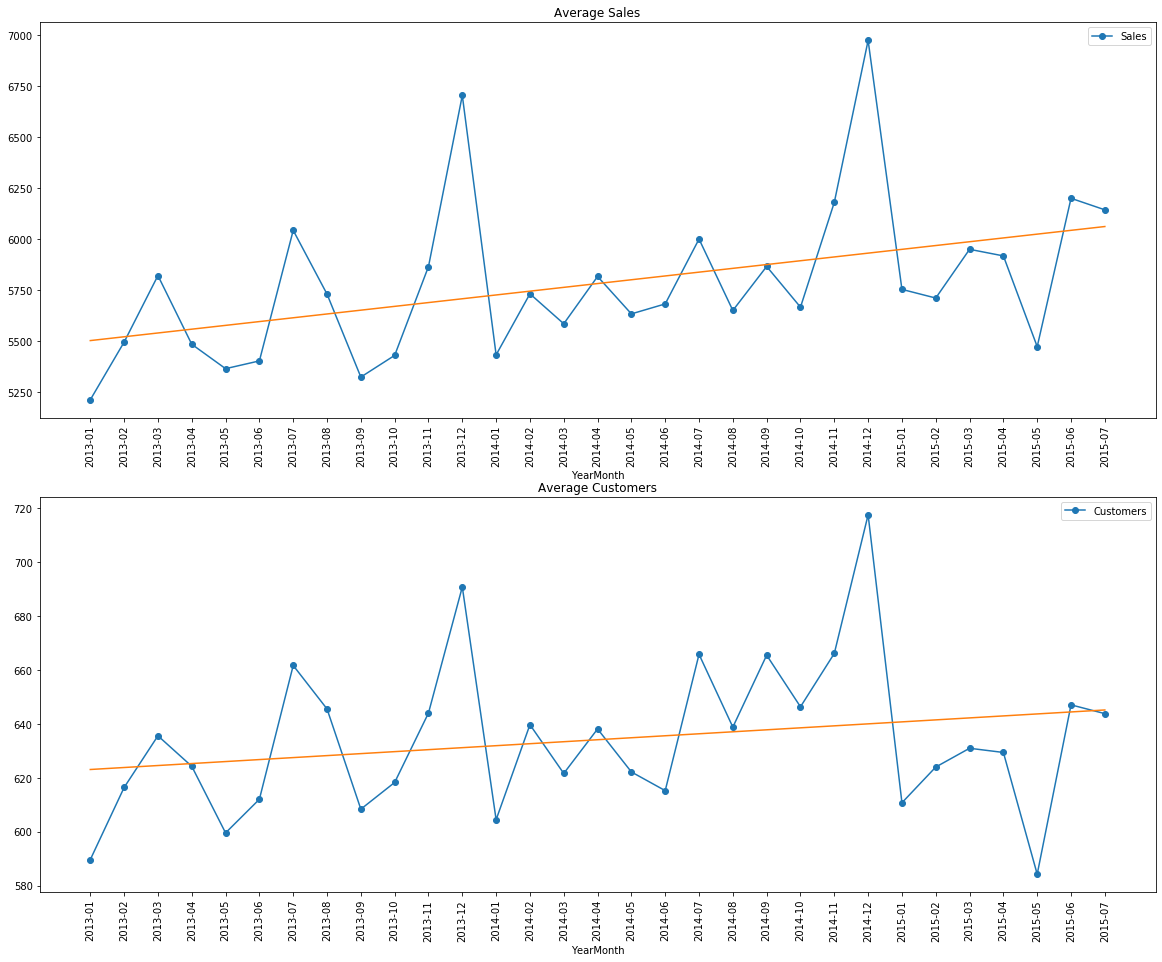

In [33]:
# group by (Year-Month) and get average Sales and Customers
average_sales = train.groupby('YearMonth')['Sales'].mean()
average_customers = train.groupby('YearMonth')['Customers'].mean()

# Linear regression
dates = range(len(train.YearMonth.unique()))
m1, b1 = np.polyfit(dates, average_sales, 1)
m2, b2 = np.polyfit(dates, average_customers, 1)



# Plot average Sales and Customers over time (Year-Month)
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 16))
ax = average_sales.plot(legend=True, ax=axis1, marker='o', title='Average Sales')
ax.plot(m1*dates + b1)
ax.set_xticks(range(len(average_sales)))
xlabels = ax.set_xticklabels(average_sales.index.tolist(), rotation=90)
ax = average_customers.plot(legend=True, ax=axis2, marker='o', title='Average Customers')
ax.plot(m2*dates + b2)
ax.set_xticks(range(len(average_customers)))
xlabels = ax.set_xticklabels(average_customers.index.tolist(), rotation=90)

`Customers` and `Sales` are very correlated variables. Let us take a closer look to correlations.

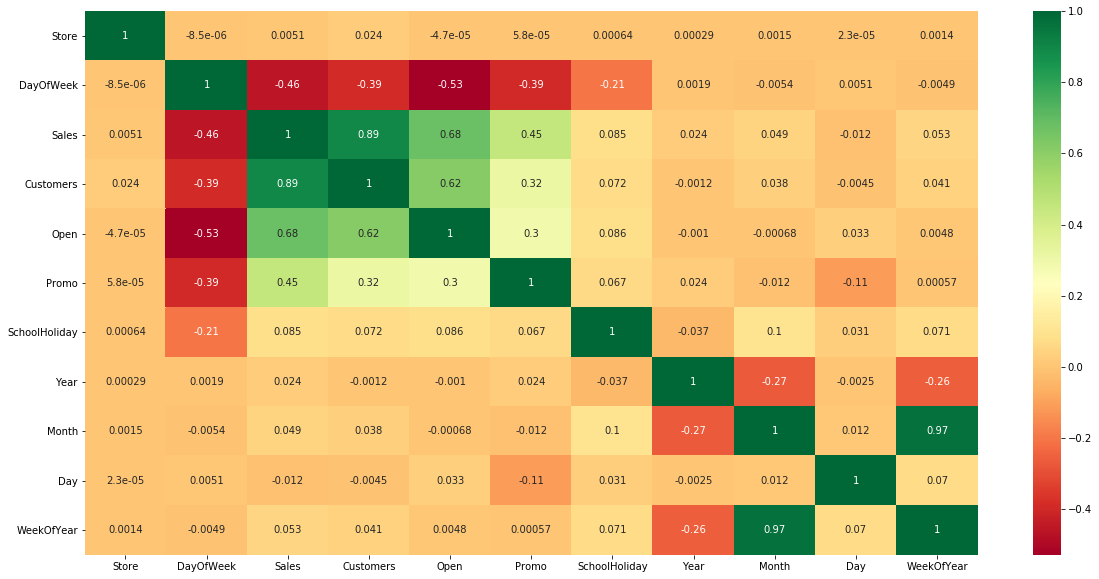

In [25]:
# Correlations
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(), annot=True, cmap="RdYlGn")

We can see that the variable most correlated with `Sales` is `Customers`. Then we can find `Open`, `DayofWeek` and `Promo`.

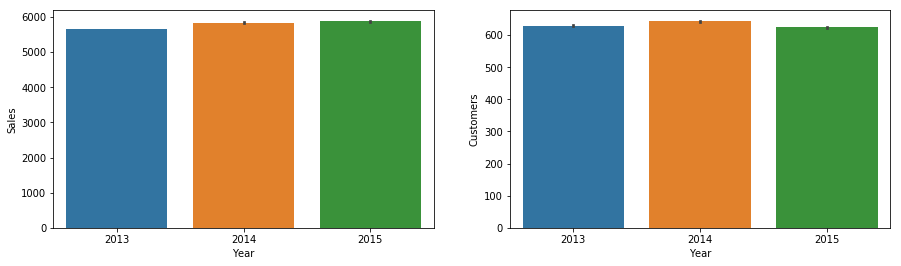

In [26]:
# Plot average Sales & Customers for every year
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

The Sales do not appear to change over the years.

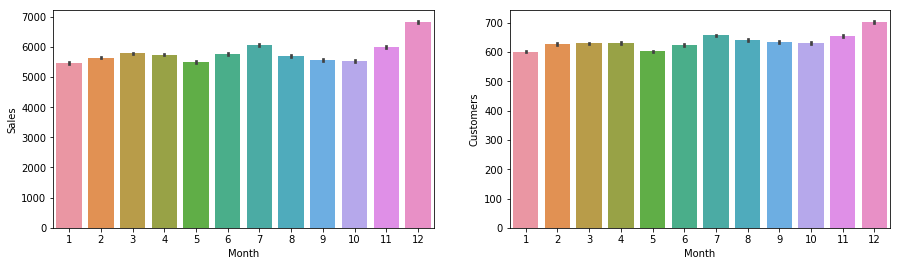

In [27]:
# Plot average Sales & Customers for every month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Month', y='Sales', data=train, ax=axis1)
sns.barplot(x='Month', y='Customers', data=train, ax=axis2)

As expected, there seems to be more sales in December, close to Christmas.

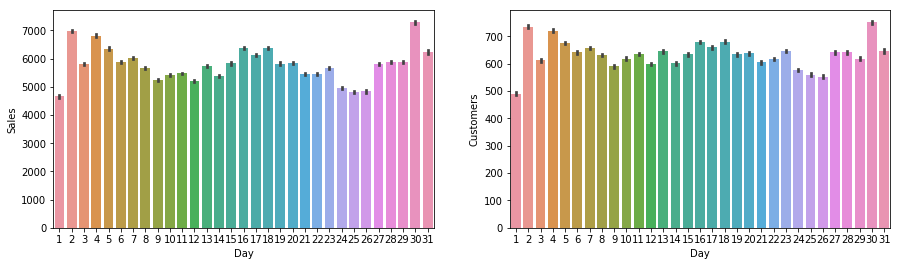

In [28]:
# Plot average Sales & Customers for every day
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Day', y='Sales', data=train, ax=axis1)
sns.barplot(x='Day', y='Customers', data=train, ax=axis2)

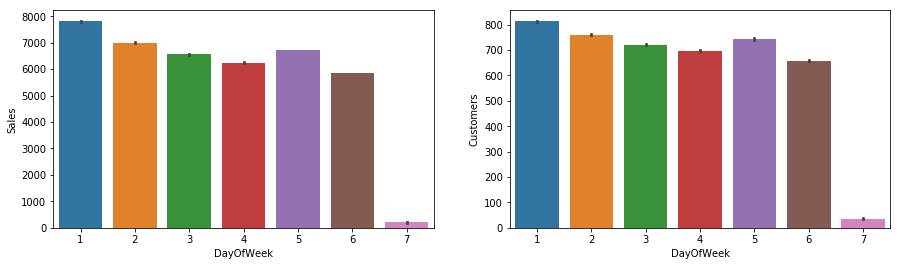

In [29]:
# Plot average Sales & Customers for every DayOfWeek
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='DayOfWeek', y='Sales', data=train, ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, ax=axis2)

As stores are often closed on Sunday, there are almost no sales. We saw that `Sales` and `DayOfWeek` are correlated, and indeed, there are more sales on Mondays and Fridays and less sales on Wednesdays.

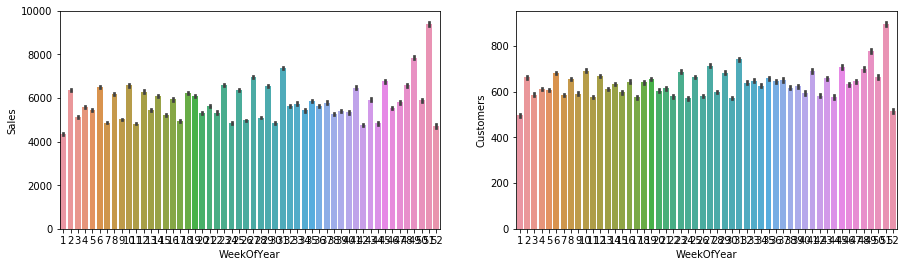

In [30]:
# Plot average sales & customers for every month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='WeekOfYear', y='Sales', data=train, ax=axis1)
sns.barplot(x='WeekOfYear', y='Customers', data=train, ax=axis2)

Again, we can see that during the year before Christmas, there are more sales than usual.

### `Promo`

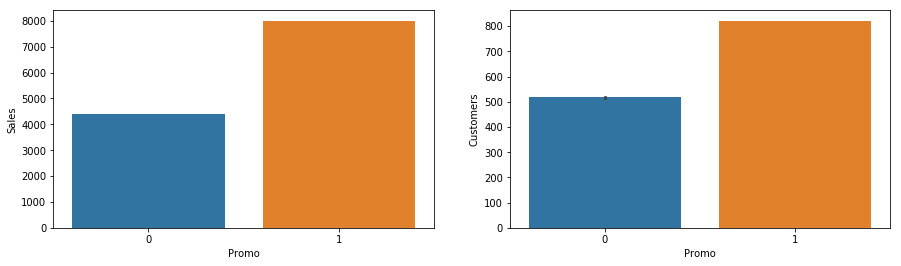

In [31]:
# Plot average Sales & Customers with/without promo
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)

We saw that `Sales` and `Promo` are correlated, and indeed, there are way more sales when there is a promo than usual.

### `StateHoliday`

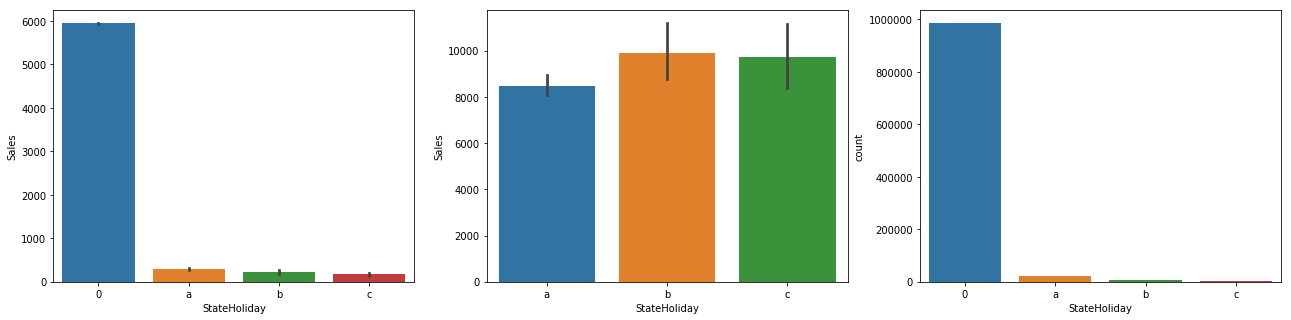

In [32]:
# StateHoliday column has values 0 & '0', So, we need to merge values with 0 to '0'
train.loc[train['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Plot
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
mask = (train['StateHoliday'] != '0') & (train['Sales'] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train[mask], ax=axis2)
sns.countplot(x='StateHoliday', data=train, ax=axis3)

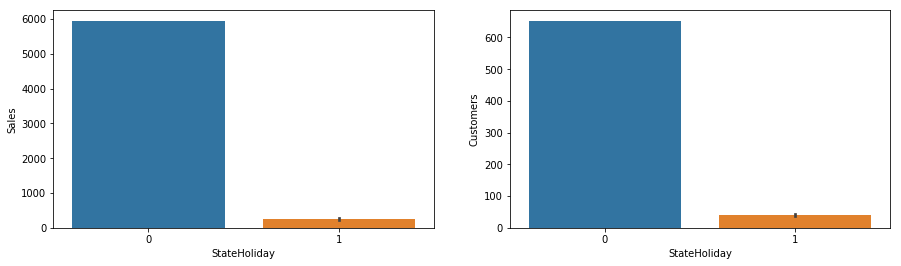

In [33]:
# Assign 1 to every StateHolidays and 0 otherwise
train['StateHoliday'] = train['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 1, 'c': 1})

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=train, ax=axis2)

### `SchoolHoliday`

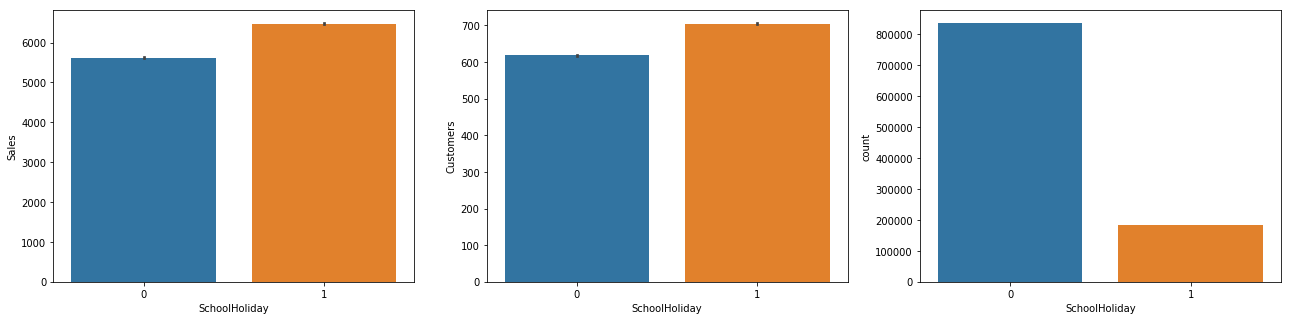

In [34]:
# Plot
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train, ax=axis2)
sns.countplot(x='SchoolHoliday', data=train, ax=axis3)

There are way more sales during a school holiday than usual.

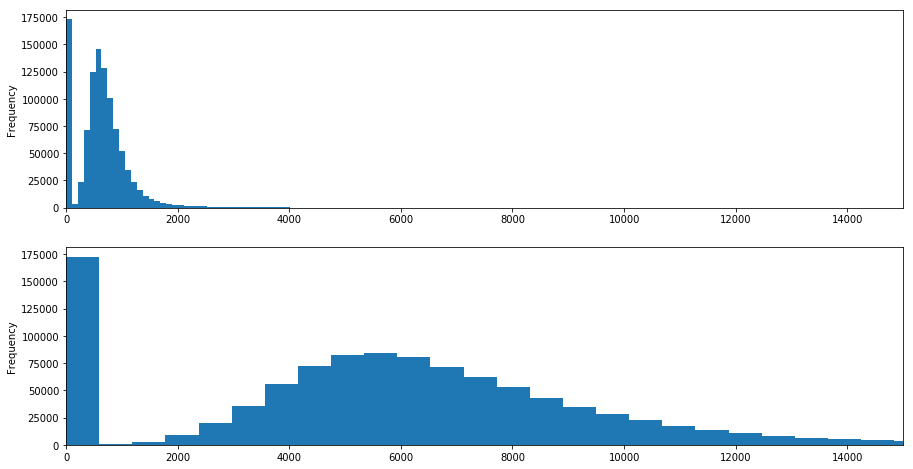

In [35]:
# Plot sales and customers values: notice that values with 0 is mostly because the store was closed
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(15, 8))
train['Customers'].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis1)
train['Sales'].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis2)

### Store data

In [36]:
# Merge store with average store Sales & Customers
average_sales_customers = train.groupby('Store')[['Sales', 'Customers']].mean()
sales_customers_df = pd.DataFrame(data = {'Store': average_sales_customers.index,
                                          'Sales': average_sales_customers['Sales'].values, 
                                          'Customers': average_sales_customers['Customers'].values}, 
                                  columns=['Store', 'Sales', 'Customers'])
store_df = pd.merge(sales_customers_df, store, on='Store')
store_df.head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


#### `StoreType`

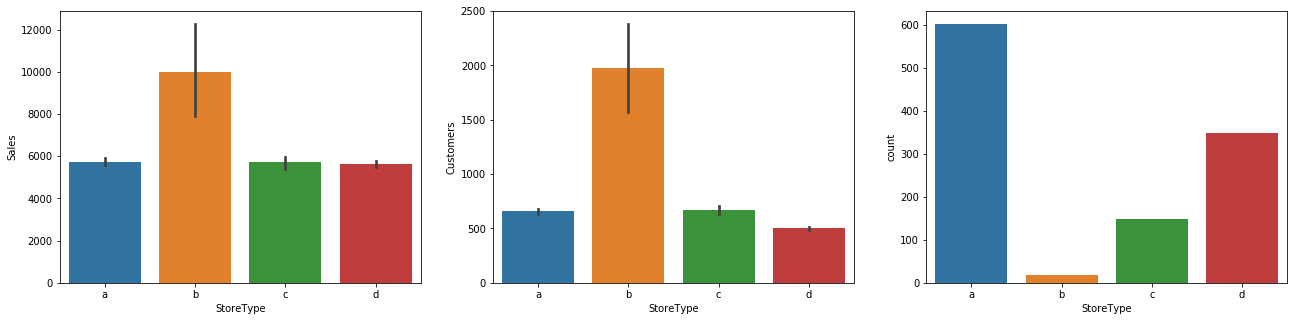

In [37]:
# Plot StoreType and StoreType vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='StoreType', y='Sales', data=store_df, order=['a','b','c', 'd'], ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=store_df, order=['a','b','c', 'd'], ax=axis2)
sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'], ax=axis3)

#### `Assortment`

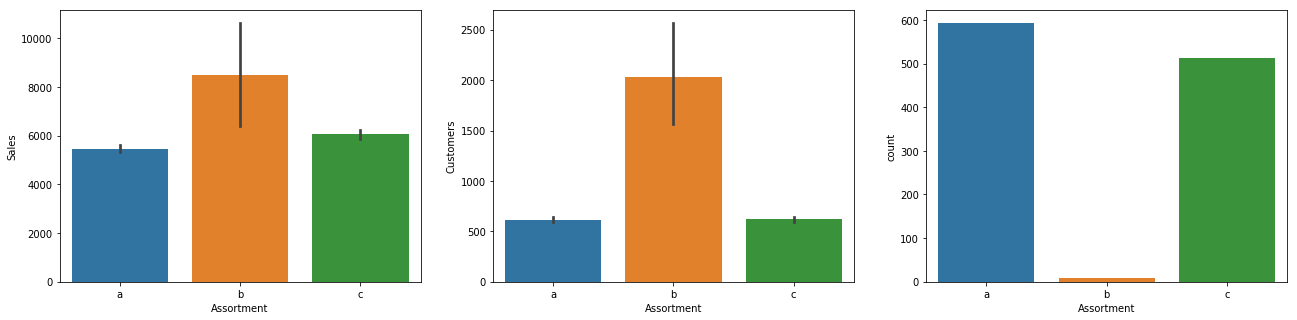

In [38]:
# Plot Assortment and Assortment vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='Assortment', y='Sales', data=store_df, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=store_df, order=['a','b','c'], ax=axis2)
sns.countplot(x='Assortment', data=store_df, order=['a','b','c'], ax=axis3)

#### `Promo2`

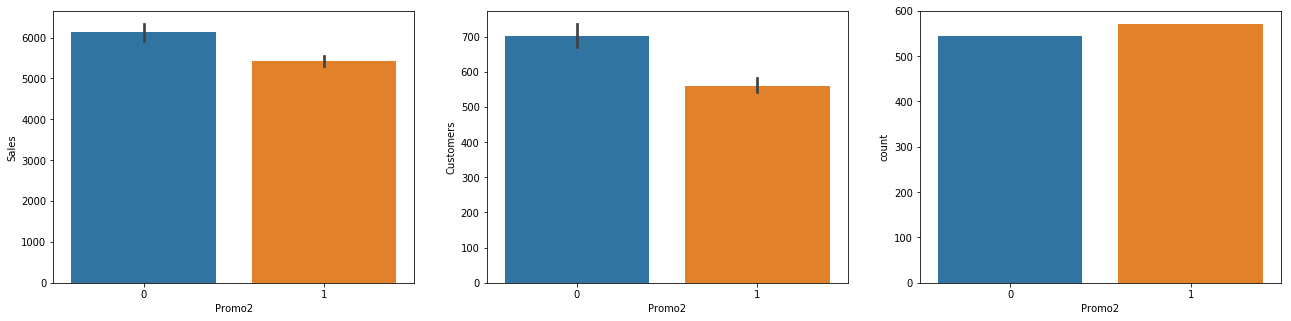

In [39]:
# Plot Promo2 and Promo2 vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='Promo2', y='Sales', data=store_df, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=store_df, ax=axis2)
sns.countplot(x='Promo2', data=store_df, ax=axis3)

#### `CompetitionDistance`

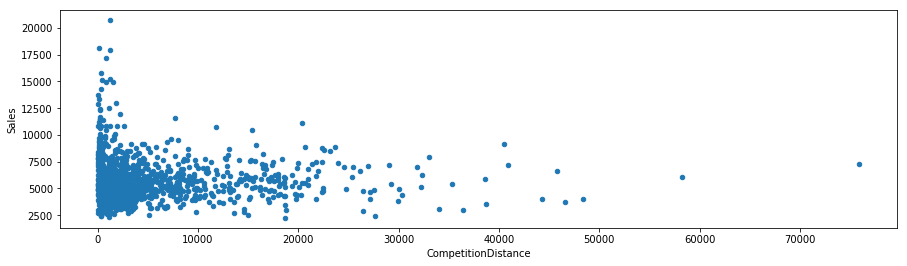

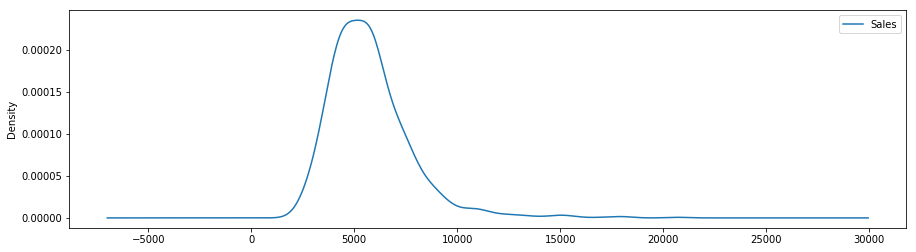

In [40]:
# CompetitionDistance fill NaN values
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace=True)

# Plot CompetitionDistance Vs Sales
store_df.plot(kind='scatter', x='CompetitionDistance', y='Sales', figsize=(15, 4))
store_df.plot(kind='kde', x='CompetitionDistance', y='Sales', figsize=(15, 4))

#### `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth`

In [41]:
store_df[(store_df['CompetitionOpenSinceYear']==2014) & (store_df['CompetitionOpenSinceMonth']==2)].head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
29,30,4367.352442,641.006369,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
44,45,4422.991507,343.505308,d,a,9710.0,2.0,2014.0,0,NaN,NaN,NaN
267,268,4062.462845,497.722930,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN


In [42]:
store_df[(store_df['CompetitionOpenSinceYear']==2013) & (store_df['CompetitionOpenSinceMonth']==12)].head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
5,6,4562.375796,525.990446,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
74,75,5013.150743,534.435244,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
580,581,4410.792994,485.962845,a,a,7250.0,12.0,2013.0,0,NaN,NaN,NaN


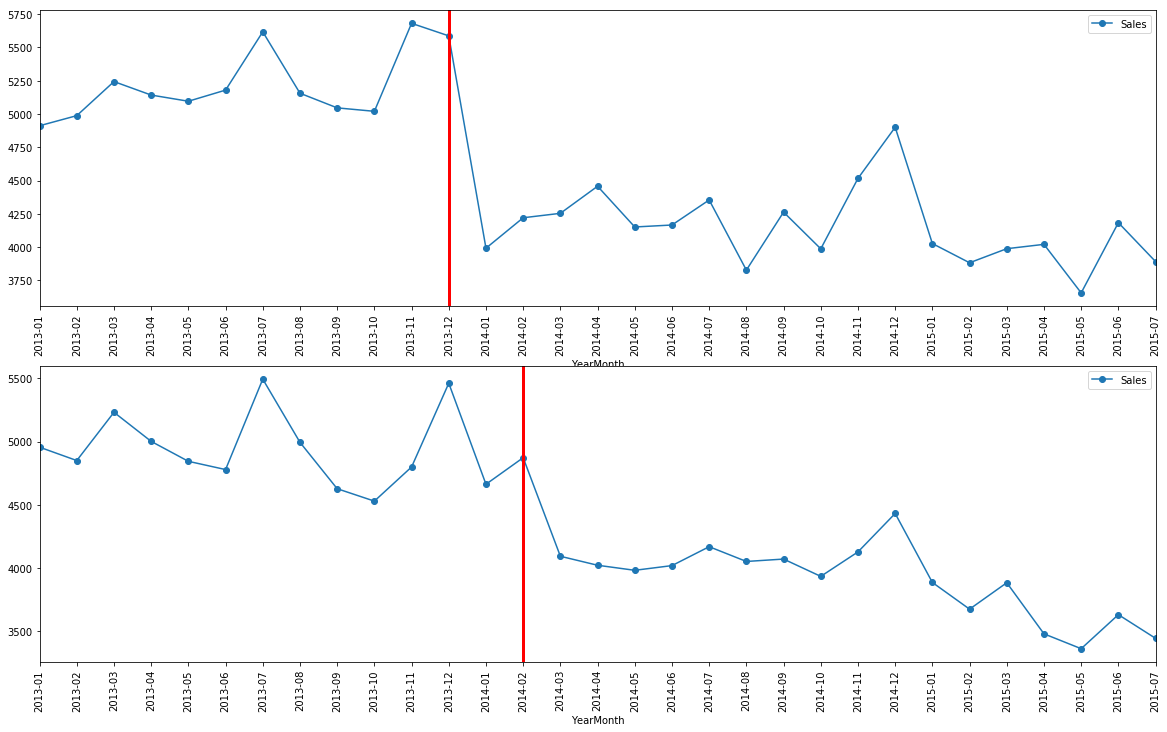

In [43]:
# Plot average Sales over time and highligth the time when Competition started
store_ids = [6, 30]
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 12))
axs = [axis1, axis2]
for (i, store_id) in enumerate(store_ids):
    store_data = train[train['Store'] == store_id]
    average_store_sales = store_data.groupby('YearMonth')['Sales'].mean()
    # Get year, and month when Competition started
    y = store_df['CompetitionOpenSinceYear'].loc[store_df['Store']  == store_id].values[0]
    m = store_df['CompetitionOpenSinceMonth'].loc[store_df['Store'] == store_id].values[0]
    # Plot 
    ax = average_store_sales.plot(legend=True, marker='o', ax=axs[i])
    axs[i].set_xticks(range(len(average_store_sales)))
    axs[i].set_xticklabels(average_store_sales.index.tolist(), rotation=90)
    axs[i].axvline(x=((y-2013)*12)+(m-1), linewidth=3, color='red')

### Merge store and train data

In [44]:
data_merged = train.merge(store, left_on='Store', right_on='Store', how='left')
data_merged.fillna(0, inplace=True)
data_merged['StoreType'] = data_merged['StoreType'].map({'a': 0, 'b': 3, 'c': 2, 'd': 1})
data_merged['Assortment'] = data_merged['Assortment'].map({'a': 0, 'b': 2, 'c': 1})
data_merged['PromoInterval'] = data_merged['PromoInterval'].map({0: 0, '0': 0, 'Jan,Apr,Jul,Oct': 1, 
                                                                 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec': 3})
data_merged.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,YearMonth,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07,...,31,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07,...,31,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,2015-07,...,31,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1


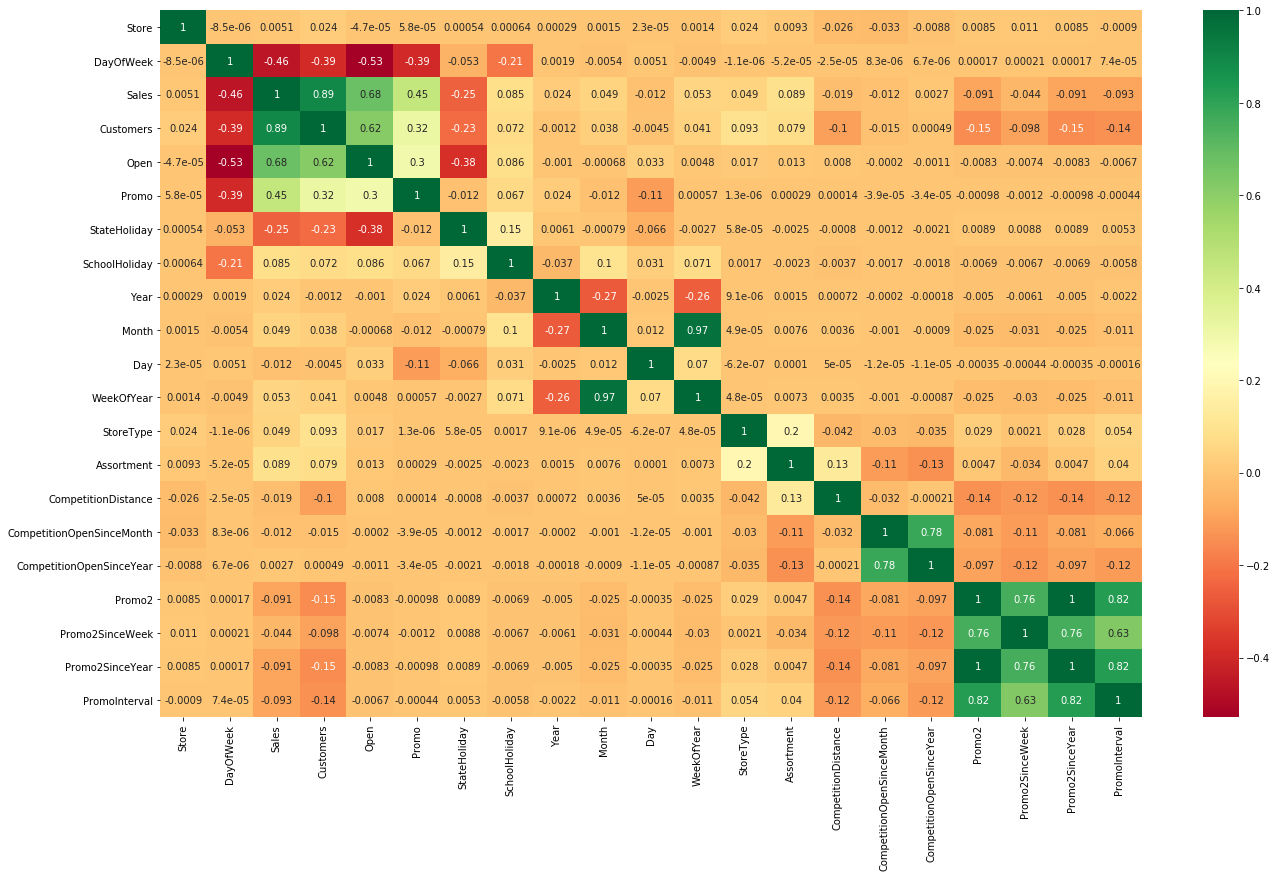

In [45]:
# Correlations
plt.figure(figsize=(22, 13))
sns.heatmap(data_merged.corr(), annot=True, cmap="RdYlGn")

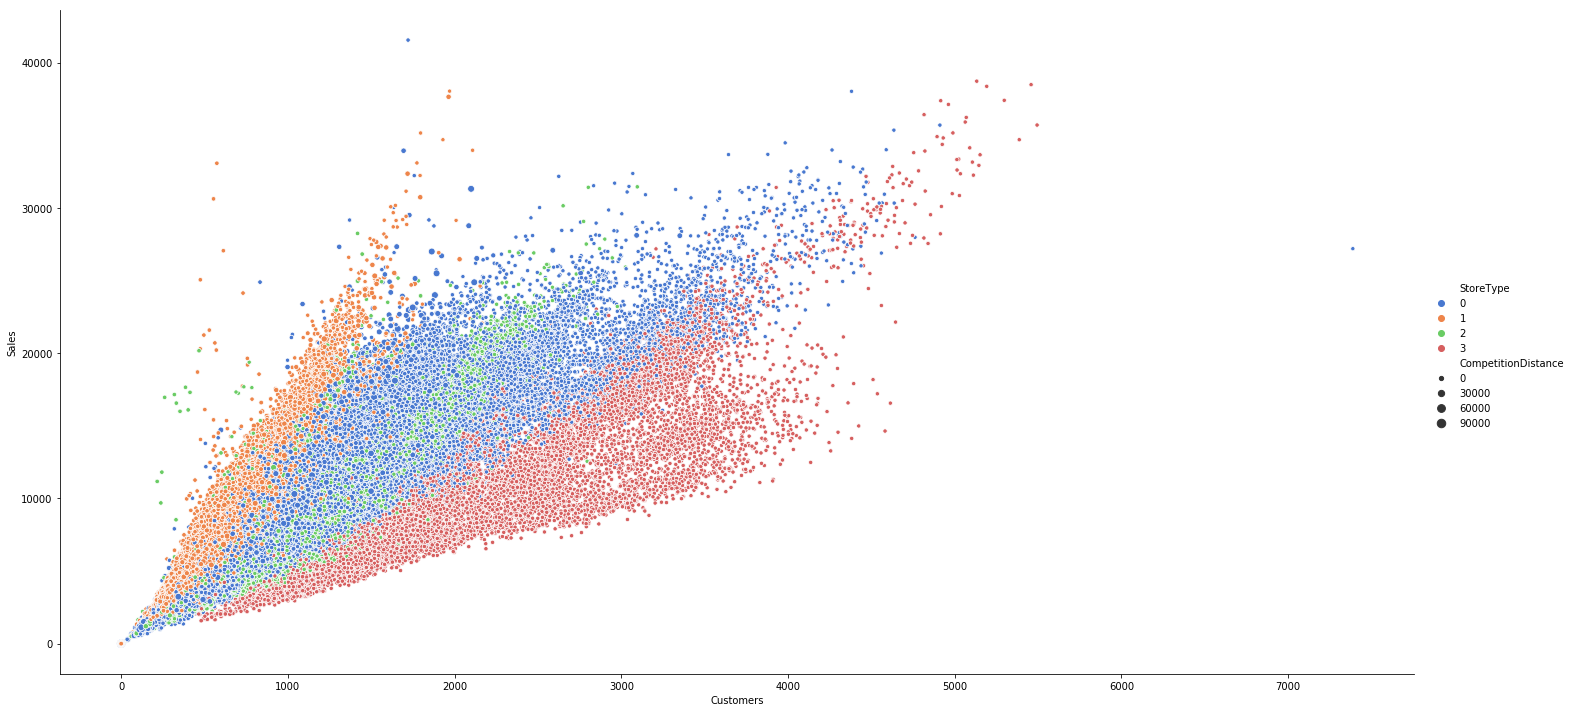

In [46]:
# Plot influence of the store type and number of customers
sns.relplot(x='Customers', y='Sales', hue='StoreType', size='CompetitionDistance',
            palette='muted', height=10, aspect=2,
            data=data_merged)

The type of store directly affects the number of customers and the sales. Stores of type 1 tends to have less customers but more sales, whereas stores of type 3 are completely the opposite.

## Model

We aim to predict store sales for any day of the year with sufficient performance based on the characteristics of the day. Care must be taken with the legitimacy of the variables used because each variable used for prediction must be known for the predicted day, otherwise the model cannot be used in prediction. Thus, we must leave aside the `Customers` feature.

We will use a XGBoost model for regression using the metric Root Mean Square Error (RMSE): 

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

### Global parameters

In [47]:
feature_map_path = results_path + 'XGBoost.fmap'
feature_importance_path = results_path + 'feature_importance.png'
params = {'objective': 'reg:linear',
          'booster' : 'gbtree',
          'subsample': 0.9,
          'silent': 1,
          'seed': 42
          }
num_boost_round = 500

### Load datasets

In [48]:
store = pd.read_csv(data_path + 'store.csv')
train = pd.read_csv(data_path + 'train.csv', low_memory=False)
test = pd.read_csv(data_path + 'test.csv')

### Preprocessing

In [49]:
# Use only Sales bigger then zero
train = train[train['Sales'] > 0]
# Save ids of closed stores, because we will assign their sales value to 0
closed_store_ids = test.loc[test['Open'] == 0, 'Id'].values

In [50]:
train_set, features = preprocessing(train, store)
test_set, _ = preprocessing(test, store)

In [63]:
print('features: \n', features)
train_set[features].head(3)

features: 
 ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']


,Store,CompetitionDistance,Promo,Promo2,SchoolHoliday,StoreType,Assortment,StateHoliday,DayOfWeek,Month,Day,Year,WeekOfYear,CompetitionOpen,PromoOpen
0,1,1270.0,1,0,1,2,0,0,5,7,31,2015,31,82.0,0.00
1,2,570.0,1,1,1,0,0,0,5,7,31,2015,31,92.0,64.50
2,3,14130.0,1,1,1,0,0,0,5,7,31,2015,31,103.0,52.25


### XGBoost model
#### Split data between train and validation sets

In [64]:
X_train, X_valid = train_test_split(train_set, test_size=0.012, random_state=10)
y_train = X_train.Sales
y_valid = X_valid.Sales
xgb_train = xgb.DMatrix(X_train[features], y_train)
xgb_valid = xgb.DMatrix(X_valid[features], y_valid)

#### Train

In [53]:
watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
gbm = xgb.train(params, xgb_train, num_boost_round, evals=watchlist,
                early_stopping_rounds=100, feval=rmse_XGBoost, verbose_eval=True)

[0]	train-rmse:5643.14	eval-rmse:5609.53	train-rmse:5643.14	eval-rmse:5609.53
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4353.1	eval-rmse:4321.05	train-rmse:4353.11	eval-rmse:4321.05
[2]	train-rmse:3536.1	eval-rmse:3507.5	train-rmse:3536.13	eval-rmse:3507.5
[3]	train-rmse:3041.77	eval-rmse:3017.71	train-rmse:3041.79	eval-rmse:3017.71
[4]	train-rmse:2759.46	eval-rmse:2738.13	train-rmse:2759.47	eval-rmse:2738.13
[5]	train-rmse:2583.71	eval-rmse:2568.6	train-rmse:2583.73	eval-rmse:2568.6
[6]	train-rmse:2493.64	eval-rmse:2480.81	train-rmse:2493.66	eval-rmse:2480.81
[7]	train-rmse:2441.76	eval-rmse:2432.29	train-rmse:2441.77	eval-rmse:2432.29
[8]	train-rmse:2368.7	eval-rmse:2360.3	train-rmse:2368.72	eval-rmse:2360.3
[9]	train-rmse:2318.27	eval-rmse:2312.78	train-rmse:2318.28	eval-rmse:2312.78
[10]	train-rmse:2302.42	eval-rmse:2297.14	train-rmse:2302.43	eval-rmse:2297.14
[11]	t

[103]	train-rmse:1155.02	eval-rmse:1163.26	train-rmse:1155.03	eval-rmse:1163.26
[104]	train-rmse:1149.48	eval-rmse:1158.71	train-rmse:1149.49	eval-rmse:1158.71
[105]	train-rmse:1145.19	eval-rmse:1155.09	train-rmse:1145.19	eval-rmse:1155.09
[106]	train-rmse:1143.24	eval-rmse:1154.09	train-rmse:1143.25	eval-rmse:1154.09
[107]	train-rmse:1139.6	eval-rmse:1150	train-rmse:1139.61	eval-rmse:1150
[108]	train-rmse:1135	eval-rmse:1145.68	train-rmse:1135.01	eval-rmse:1145.68
[109]	train-rmse:1131.28	eval-rmse:1142.47	train-rmse:1131.28	eval-rmse:1142.47
[110]	train-rmse:1127.77	eval-rmse:1139.86	train-rmse:1127.78	eval-rmse:1139.86
[111]	train-rmse:1123.15	eval-rmse:1135.85	train-rmse:1123.16	eval-rmse:1135.85
[112]	train-rmse:1118.86	eval-rmse:1131.82	train-rmse:1118.86	eval-rmse:1131.82
[113]	train-rmse:1114.5	eval-rmse:1127.62	train-rmse:1114.51	eval-rmse:1127.62
[114]	train-rmse:1110.45	eval-rmse:1123.49	train-rmse:1110.46	eval-rmse:1123.49
[115]	train-rmse:1104.99	eval-rmse:1117.56	train-rm

[207]	train-rmse:932.077	eval-rmse:955.593	train-rmse:932.083	eval-rmse:955.593
[208]	train-rmse:930.242	eval-rmse:953.947	train-rmse:930.248	eval-rmse:953.947
[209]	train-rmse:928.885	eval-rmse:952.627	train-rmse:928.891	eval-rmse:952.627
[210]	train-rmse:927.811	eval-rmse:951.5	train-rmse:927.818	eval-rmse:951.5
[211]	train-rmse:926.459	eval-rmse:950.344	train-rmse:926.465	eval-rmse:950.344
[212]	train-rmse:925.048	eval-rmse:948.628	train-rmse:925.053	eval-rmse:948.628
[213]	train-rmse:923.256	eval-rmse:947.104	train-rmse:923.261	eval-rmse:947.104
[214]	train-rmse:922.415	eval-rmse:946.263	train-rmse:922.42	eval-rmse:946.263
[215]	train-rmse:921.414	eval-rmse:945.33	train-rmse:921.419	eval-rmse:945.33
[216]	train-rmse:920.188	eval-rmse:944.314	train-rmse:920.193	eval-rmse:944.314
[217]	train-rmse:919.716	eval-rmse:943.92	train-rmse:919.721	eval-rmse:943.919
[218]	train-rmse:917.286	eval-rmse:941.062	train-rmse:917.291	eval-rmse:941.062
[219]	train-rmse:915.692	eval-rmse:939.401	train

[311]	train-rmse:839.503	eval-rmse:866.865	train-rmse:839.508	eval-rmse:866.865
[312]	train-rmse:839.247	eval-rmse:866.618	train-rmse:839.252	eval-rmse:866.618
[313]	train-rmse:838.433	eval-rmse:865.91	train-rmse:838.438	eval-rmse:865.91
[314]	train-rmse:838.156	eval-rmse:865.739	train-rmse:838.161	eval-rmse:865.739
[315]	train-rmse:837.697	eval-rmse:865.216	train-rmse:837.702	eval-rmse:865.216
[316]	train-rmse:836.813	eval-rmse:863.556	train-rmse:836.819	eval-rmse:863.556
[317]	train-rmse:835.673	eval-rmse:862.621	train-rmse:835.678	eval-rmse:862.621
[318]	train-rmse:834.911	eval-rmse:861.939	train-rmse:834.917	eval-rmse:861.939
[319]	train-rmse:834.155	eval-rmse:861.494	train-rmse:834.16	eval-rmse:861.494
[320]	train-rmse:833.599	eval-rmse:861.08	train-rmse:833.604	eval-rmse:861.08
[321]	train-rmse:833.323	eval-rmse:860.889	train-rmse:833.328	eval-rmse:860.888
[322]	train-rmse:833.086	eval-rmse:860.786	train-rmse:833.091	eval-rmse:860.786
[323]	train-rmse:831.862	eval-rmse:859.927	tr

[414]	train-rmse:785.288	eval-rmse:816.609	train-rmse:785.293	eval-rmse:816.609
[415]	train-rmse:784.844	eval-rmse:816.307	train-rmse:784.849	eval-rmse:816.307
[416]	train-rmse:784.328	eval-rmse:815.709	train-rmse:784.333	eval-rmse:815.709
[417]	train-rmse:784.061	eval-rmse:815.545	train-rmse:784.066	eval-rmse:815.545
[418]	train-rmse:783.645	eval-rmse:815.335	train-rmse:783.65	eval-rmse:815.335
[419]	train-rmse:783.394	eval-rmse:815.174	train-rmse:783.398	eval-rmse:815.174
[420]	train-rmse:782.878	eval-rmse:814.507	train-rmse:782.883	eval-rmse:814.508
[421]	train-rmse:782.553	eval-rmse:814.032	train-rmse:782.558	eval-rmse:814.032
[422]	train-rmse:781.985	eval-rmse:813.565	train-rmse:781.99	eval-rmse:813.565
[423]	train-rmse:781.762	eval-rmse:813.405	train-rmse:781.767	eval-rmse:813.405
[424]	train-rmse:781.307	eval-rmse:813.258	train-rmse:781.312	eval-rmse:813.258
[425]	train-rmse:780.755	eval-rmse:812.887	train-rmse:780.76	eval-rmse:812.887
[426]	train-rmse:780.459	eval-rmse:812.651	

#### Validate

In [65]:
y_pred = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmse(X_valid.Sales.values, y_pred)
print('RMSE: {:.6f}'.format(error))

RMSE: 790.297899


In [66]:
valid = X_valid.copy()
valid['Predicted_sales'] = y_pred
valid = valid.sort_values(by='Date')

##### Sum of the Sales VS Sum of the Predicted Sales on the Validation set of all stores

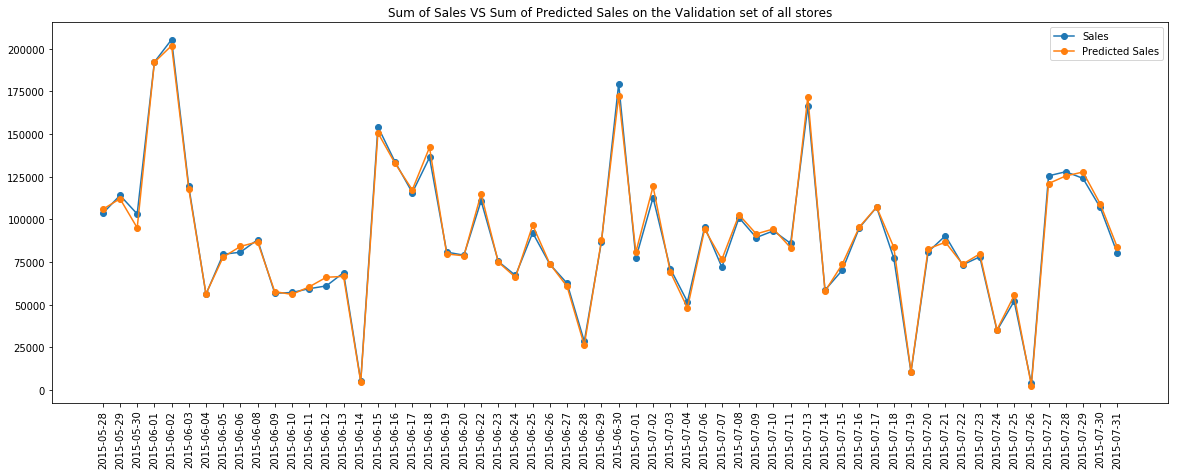

In [67]:
time_range = 60
valid_by_dates = valid.groupby('Date').sum()[['Sales', 'Predicted_sales']]
valid_by_dates = valid_by_dates.iloc[-time_range:,:]

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(range(len(valid_by_dates)), valid_by_dates.Sales, marker='o', label='Sales')
plt.plot(range(len(valid_by_dates)), valid_by_dates.Predicted_sales, marker='o', label='Predicted Sales')
ax.set_xticks(range(len(valid_by_dates)))
xlabels = ax.set_xticklabels([str(x)[:-9] for x in valid_by_dates.index.tolist()], rotation=90)
plt.title('Sum of Sales VS Sum of Predicted Sales on the Validation set of all stores')
plt.legend()
plt.savefig(results_path + 'valid_sum_sales.png')
plt.show()

##### Sales VS Predicted Sales on the Validation set for specific stores

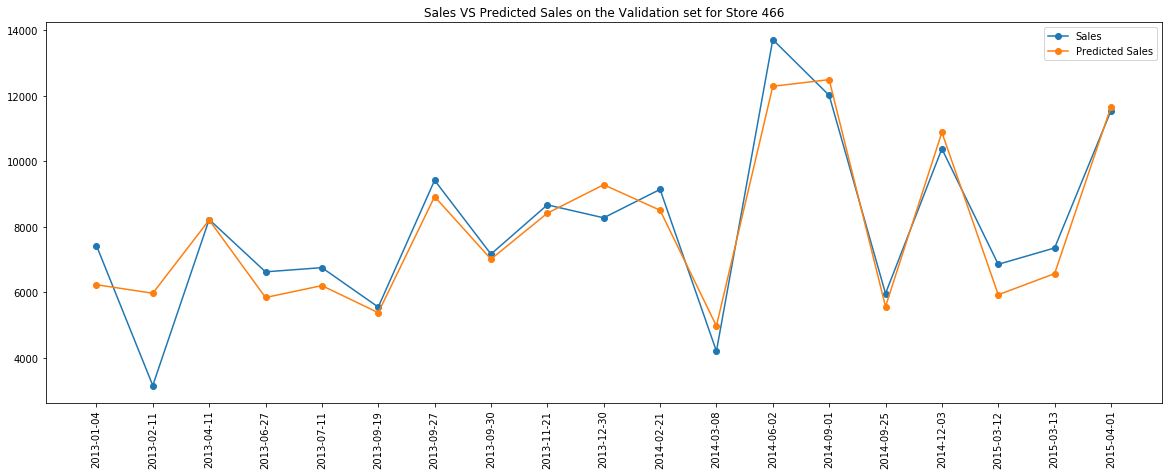

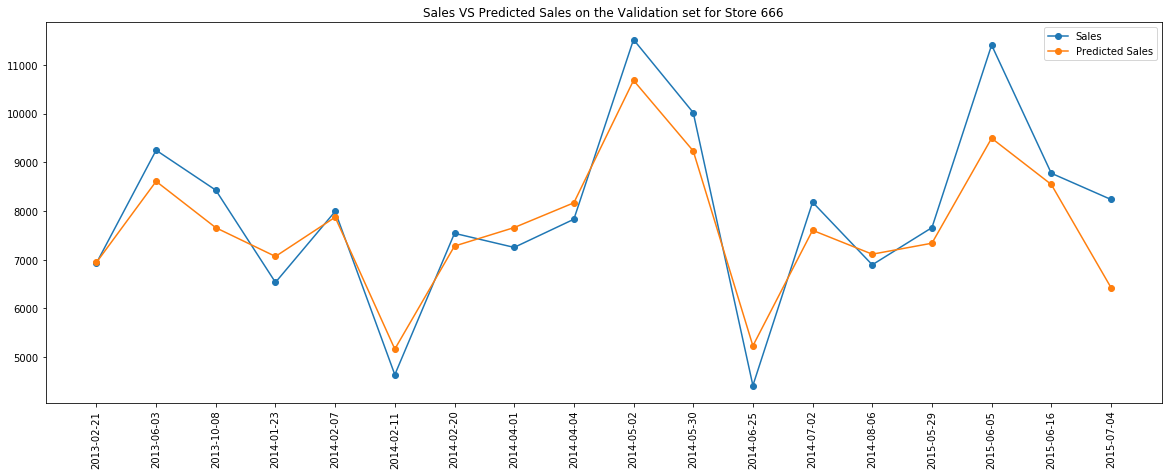

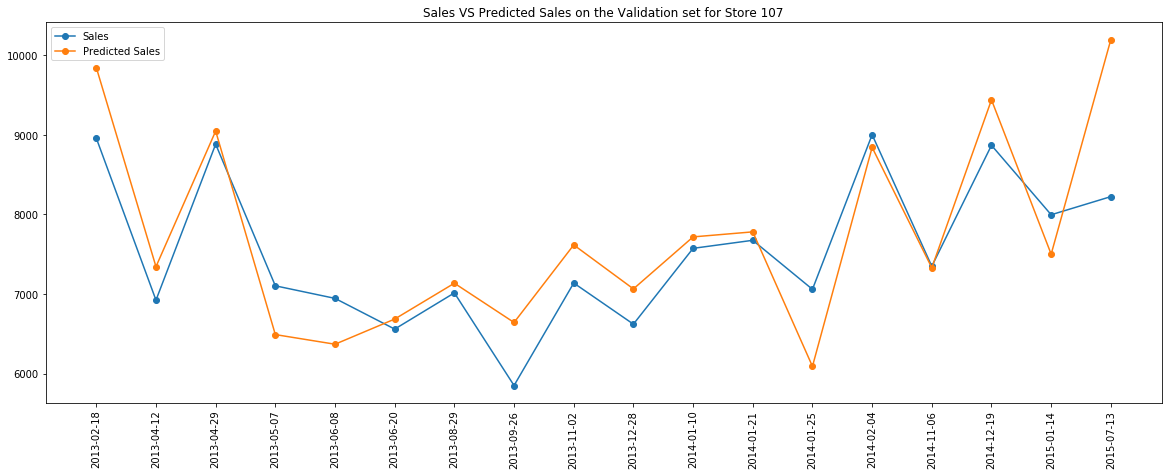

In [68]:
stores = [466, 666, 107]
for store in stores:
    store_df = valid[valid['Store'] == store]
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(range(len(store_df)), store_df.Sales, marker='o', label='Sales')
    plt.plot(range(len(store_df)), store_df.Predicted_sales, marker='o', label='Predicted Sales')
    ax.set_xticks(range(len(store_df)))
    xlabels = ax.set_xticklabels(store_df.Date.apply(lambda x: str(x)[:-9]).tolist(), rotation=90)
    plt.title('Sales VS Predicted Sales on the Validation set for Store ' + str(store))
    plt.legend()
    plt.savefig(results_path + 'valid_sales_store_' + str(store) + '.png')
    plt.show()

#### Prediction on the test set

In [69]:
xbg_test = xgb.DMatrix(test_set[features])
test_pred = gbm.predict(xbg_test)

In [70]:
# append ids that were closed, and assign their sales value to 0
result = pd.DataFrame({'Id': test_set['Id'], 'Predicted_sales': test_pred})
result = result.append(pd.DataFrame(data=zip(closed_store_ids, [0]*len(closed_store_ids)), 
                                    columns=['Id', 'Predicted_sales']))
test_results = test.merge(result, left_on='Id', right_on='Id').sort_values(by='Date')
test_results.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Predicted_sales
41087,41088,1115,6,2015-08-01,1.0,0,0,1,7914.587891
40522,40523,378,6,2015-08-01,1.0,0,0,0,6817.447266
40521,40522,377,6,2015-08-01,1.0,0,0,0,7192.214844


##### Sum of the predicted sales on the test set for all stores

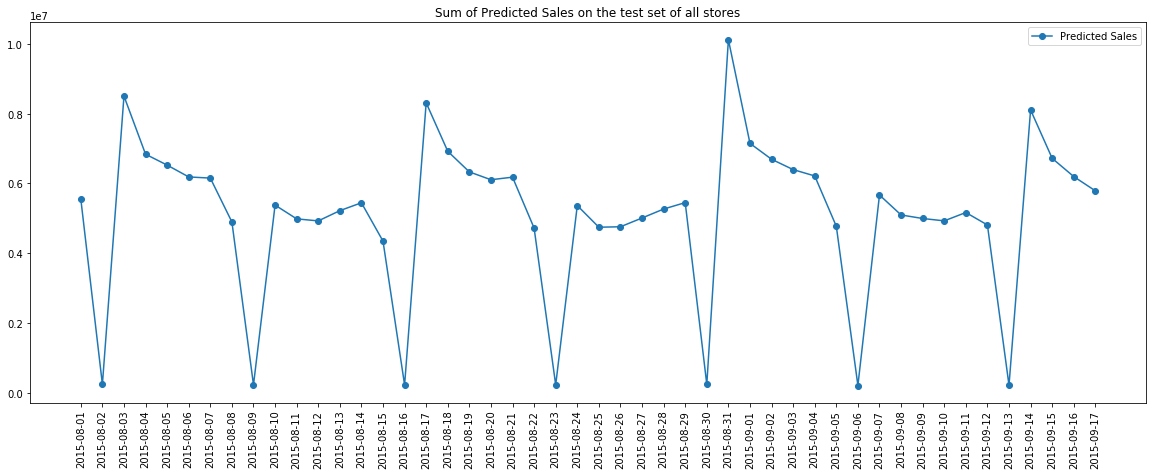

In [71]:
test_by_dates = test_results.groupby('Date').sum()[['Predicted_sales']]

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(range(len(test_by_dates)), test_by_dates.Predicted_sales, marker='o', label='Predicted Sales')
ax.set_xticks(range(len(test_by_dates)))
xlabels = ax.set_xticklabels([str(x)[:-9] for x in test_by_dates.index.tolist()], rotation=90)
plt.title('Sum of Predicted Sales on the test set of all stores')
plt.legend()
plt.savefig(results_path + 'test_sum_sales.png')
plt.show()

##### Predicted Sales on the test set for specific stores

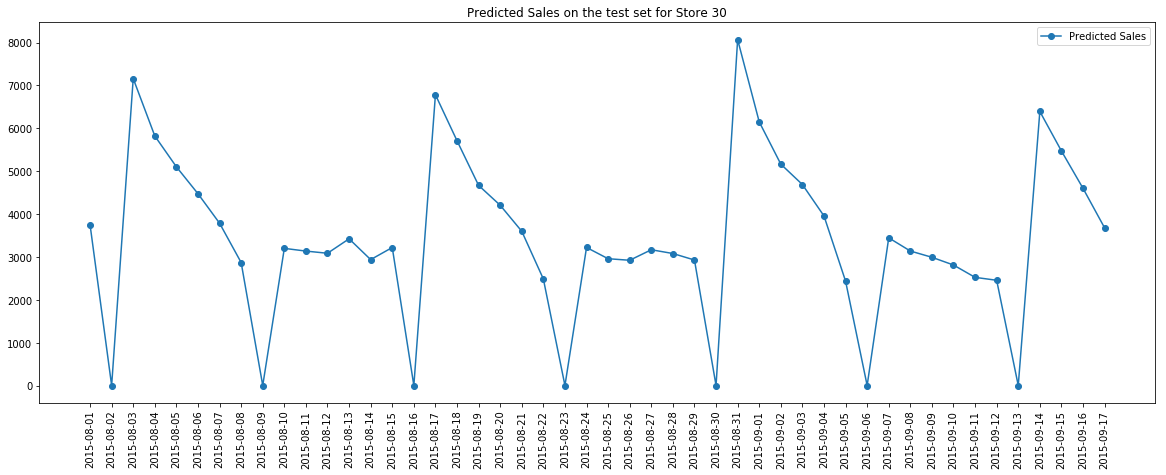

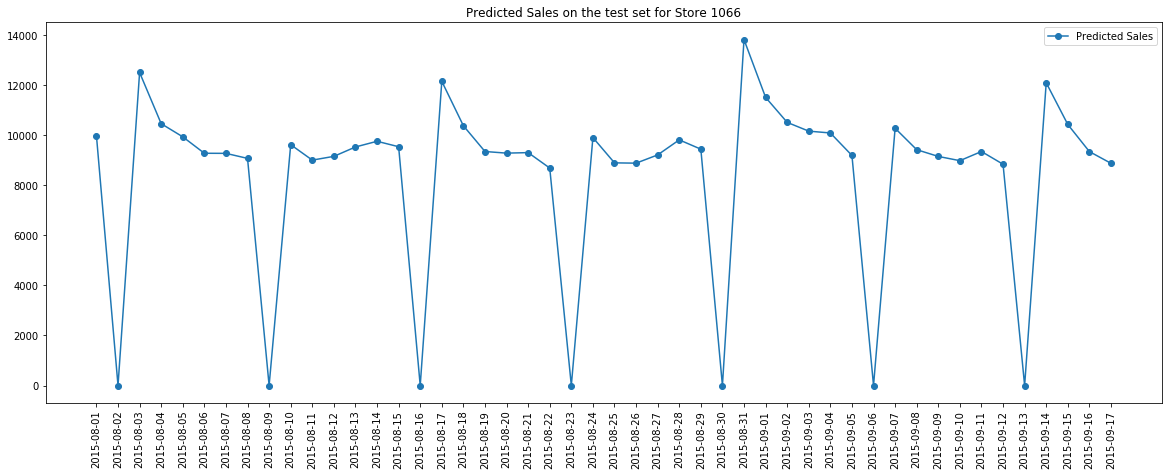

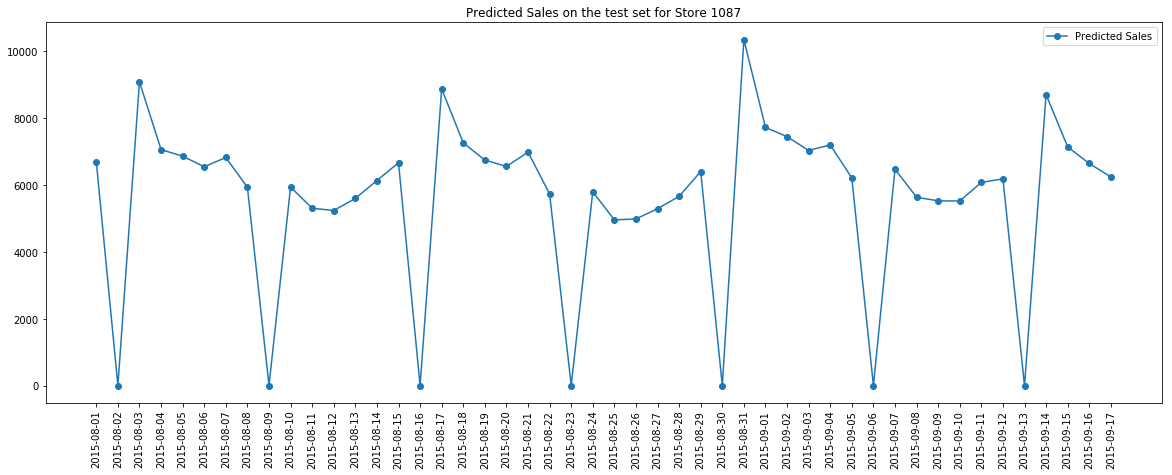

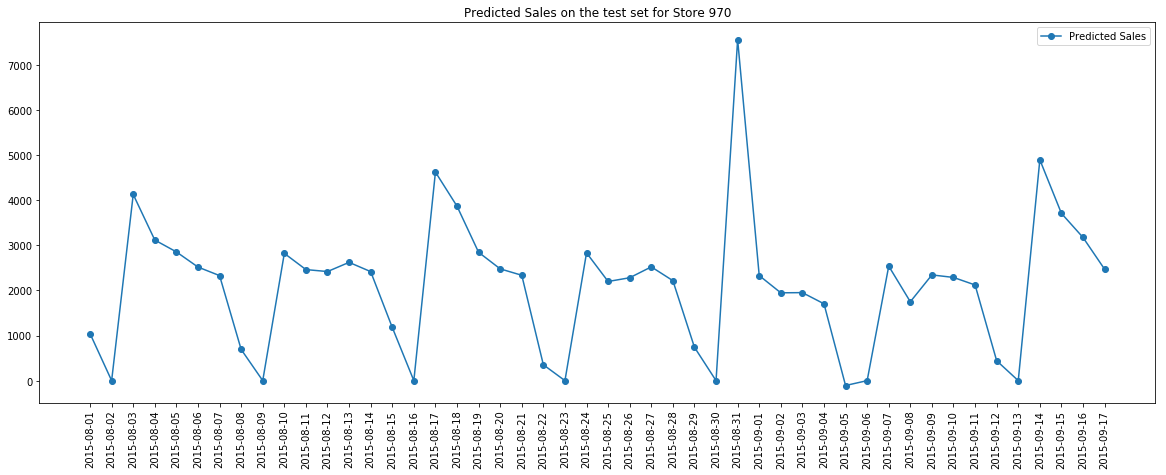

In [72]:
stores = [30, 1066, 1087, 970]
for store in stores:
    store_df = test_results[test_results['Store'] == store]
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(range(len(store_df)), store_df.Predicted_sales, marker='o', label='Predicted Sales')
    ax.set_xticks(range(len(store_df)))
    xlabels = ax.set_xticklabels(store_df.Date.apply(lambda x: str(x)[:-9]).tolist(), rotation=90)
    plt.title('Predicted Sales on the test set for Store ' + str(store))
    plt.legend()
    plt.savefig(results_path + 'test_sales_store_' + str(store) + '.png')
    plt.show()

#### Feature Importance

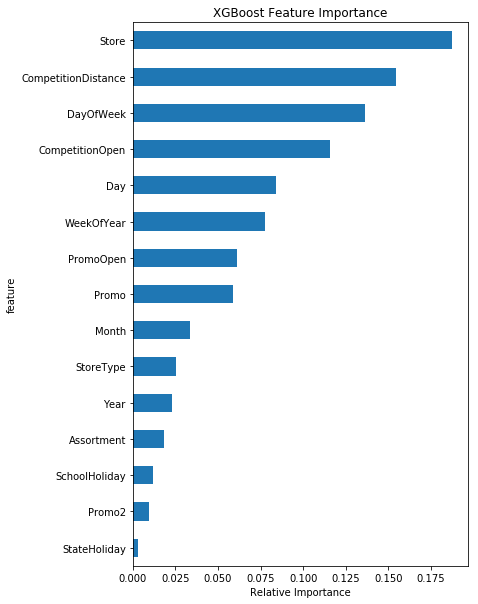

In [73]:
create_feature_map(features, feature_map_path)
importance = gbm.get_fscore(fmap=feature_map_path)
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
fimp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('Relative Importance')
fig_fimp = fimp.get_figure()
fig_fimp.savefig(feature_importance_path, bbox_inches='tight', pad_inches=1)